# Enrichment scoring for feature selection
In this notebook, we show a small example of how to select signficantly enriched genes for feature selection.

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from umap import UMAP as umap
from sklearn.decomposition import PCA

from SEMITONES.enrichment_scoring import calculate_escores
from SEMITONES.enrichment_scoring import permute
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary

## 1. Load the data

In [2]:
os.chdir("../nestorowa")

In [3]:
data = pd.read_hdf("nestorowa_processed.h5")  # counts
PC20 = np.loadtxt("nestorowa_20PC.txt", delimiter="\t")  # top 20 PCs
UMAP = np.loadtxt("nestorowa_UMAP.txt", delimiter="\t")  # 2D UMAP

In [4]:
with open("nestorowa_dd_rcells.txt", "r") as f:
    r_cells = [int(c.strip("\n")) for c in f.readlines()]
f.close()

We will perform dimensionality reduction and hope to get a better separation of the cell populations in our data. We only use the HVGs for speed of our computations. Normally, this strategy can be used on all expressed genes.

## 2. Create the similarity matrix

In [5]:
g = 8.6e-4

In [6]:
S = pairwise_similarities(PC20,  # similarities in the 20 PC space
                          query=r_cells,  # only to the reference cells
                          metric="rbf",  # metric as in notebook 1
                          metric_params={"gamma": g})

## 3. Calculate enrichment scores

We don't do any mapping since we will not inspect the genes per cell so we will run using a numpy array (.values)

In [7]:
escores = calculate_escores(data.values, query=r_cells, S=S)  # calculcate scores

Start enrichment scoring using 32 CPUs
Creating process pool
Run enrichment scoring
Enrichment scoring complete


We then determine our signficantly enriched genes

In [8]:
P = permute(data.values)  # make sure to use a numpy matrix

In [9]:
pscores = calculate_escores(P, query=r_cells, S=S)

Start enrichment scoring using 32 CPUs
Creating process pool
Run enrichment scoring
Enrichment scoring complete


In [10]:
interval = sig_interval(pscores, n_sds=8)  # not very restrictive

In [11]:
sigdict = sig_dictionary(escores, interval)

We get a list of signficantly erniched genes in all cells and subset our data

In [12]:
subset = list({x for v in sigdict.values() for x in v})  # get a set of all values in the dictionary

In [13]:
len(subset)

1328

In [14]:
subset = data.iloc[:, subset]

## 4. Dimensionality reduction and visualization

In [15]:
PCA20 = PCA(n_components=20).fit_transform(subset.values)  # PCA on the subset
newUMAP = umap().fit_transform(PCA20)  # UMAP on PCA

Plot a comparison of the UMAPs

In [16]:
annotations = {
    "HSPC_117": ["DC", "#fcba03"],
    "HSPC_232": ["pro/preB", "#03e7fc"],
    "HSPC_336": ["T commited", "#c689f0"],
    "LT-HSC_044": ["Unknown", "#2c292e"],
    "LT-HSC_068": ["HSC", "#d1be8c"],
    "LT-HSC_077": ["B", "#0011ff"],
    "LT-HSC_124": ["CMP", "#00bf93"],
    "Prog_029": ["Erythrocyte", "#fc0303"],
    "Prog_182": ["eo/baso/mast", "#fcdf03"],
    "Prog_210": ["CLP", "#6c96a3"],
    "Prog_369": ["Erythrocyte", "#fc0303"],
    "Prog_487": ["GMP/Neutrophil", "#ff9100"],
    "Prog_488": ["CLP", "#6c96a3"],
    "Prog_729": ["T", "#9803fc"],
    "Prog_734": ["MEP", "#c78c7b"],
    "Prog_736": ["Megakaryocyte", "#fc4a03"],
    "Prog_775": ["CMP", "#00bf93"]
}
order = ["HSC", "CMP", "GMP/Neutrophil", "eo/baso/mast", "DC",
         "CLP", "pro/preB", "B", "T commited", "T",
         "MEP", "Erythrocyte", "Megakaryocyte", "Unknown"]
colors = [x[1] for x in annotations.values()]
annots = [x[0] for x in annotations.values()]
coldict = dict(zip(annots, colors))
legend = {k: coldict[k] for k in order}
marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="", markersize=2)
          for c in legend.values()]

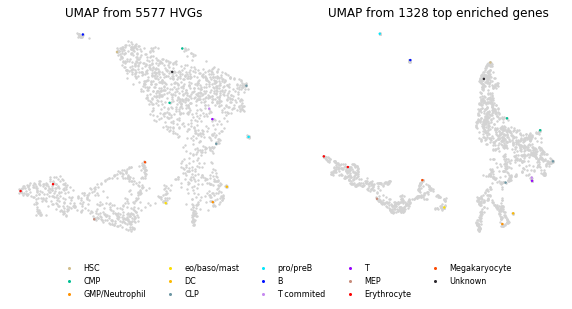

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
for ax, U in zip(axs, [UMAP, newUMAP]):
    ax.scatter(U[:, 0], U[:, 1], s=2, color="lightgrey")
    ax.scatter(U[r_cells, 0], U[r_cells, 1], s=2, color=colors)
    ax.axis("off")
axs[0].set_title("UMAP from 5577 HVGs")
axs[1].set_title("UMAP from 1328 top enriched genes")
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=8, ncol=5,
                 loc="lower center", bbox_to_anchor=(-.1, -0.3))
leg.get_frame().set_linewidth(0.0)